<a href="https://colab.research.google.com/github/robgon-art/BIG.art/blob/main/2_Finetune_ChatGPT_MD_Formatting_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune-ChatGPT
## How you can fine-tune OpenAI's GPT-3.5 Turbo model to perform new tasks using your custom data


In [1]:
!pip install openai tiktoken
!gdown 15_92FZ9FgINnxYcvu7TYzx0GPXY9jsVp
!gdown 15Vib6A4h82G4X467x_AGypFW-GBJd5gm
!unzip robgon_article_parts_txt.zip
!unzip robgon_article_parts_md.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.7 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=15_92FZ9FgINnxYcvu7TYzx0GPXY9jsVp
To: /content/robgon_article_parts_txt.zip
100% 319k/319k [00:00<00:00, 80.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=15Vib6A4h82G4X467x_AGypFW-GBJd5gm
To: /content/robgon_article_parts_md.zip
100% 315k/315k [00:00<00:00, 72.7MB/s]
Archive:  robgon_article_parts_txt.zip
  inflating: robgon_article_parts_txt/2020-08-03_machineray-using-ai-to-create-abstract-ar_1.txt  
  inflating: robgon_article_parts_txt/2020-08-03_machineray-using-ai-to-create-abstract-ar_2.txt  
  inflating: robgon_article_parts_txt/2020-08-03_machineray-using-ai-to-create-abstract-ar_3.txt  
  inflating: robgon_article_parts_txt/2020-08-03_machineray-using-ai-to-create-abstract-ar_4.txt  
  inflating: robgon_article_parts_txt/2020-09-01_got-writers-block-it-s-p

In [ ]:
import os
import openai
openai.api_key = "your_api_key"

In [2]:
import glob
txt_files = glob.glob('/content/robgon_article_parts_txt/*.txt')
print(len(txt_files))
txt_files.sort()
for h in txt_files[-12:]:
  print(h)

md_files = glob.glob('/content/robgon_article_parts_md/*.md')
print(len(md_files))
md_files.sort()
for h in md_files[-12:]:
  print(h)

144
/content/robgon_article_parts_txt/2023-05-10_writing-songs-with-gpt-4-part-2-chords_1.txt
/content/robgon_article_parts_txt/2023-05-10_writing-songs-with-gpt-4-part-2-chords_2.txt
/content/robgon_article_parts_txt/2023-05-10_writing-songs-with-gpt-4-part-2-chords_3.txt
/content/robgon_article_parts_txt/2023-05-10_writing-songs-with-gpt-4-part-2-chords_4.txt
/content/robgon_article_parts_txt/2023-06-14_writing-songs-with-gpt-4-part-3-melodies_1.txt
/content/robgon_article_parts_txt/2023-06-14_writing-songs-with-gpt-4-part-3-melodies_2.txt
/content/robgon_article_parts_txt/2023-06-14_writing-songs-with-gpt-4-part-3-melodies_3.txt
/content/robgon_article_parts_txt/2023-06-14_writing-songs-with-gpt-4-part-3-melodies_4.txt
/content/robgon_article_parts_txt/2023-07-25_muybridge-derby-bringing-animal-locomotion-photographs-to-life-with-ai_1.txt
/content/robgon_article_parts_txt/2023-07-25_muybridge-derby-bringing-animal-locomotion-photographs-to-life-with-ai_2.txt
/content/robgon_article_

In [3]:
import json
train_file = open("training.jsonl", "w")
test_file = open("testing.jsonl", "w")

system_prompt = "You render plain text into markdown format."

for i, (txt_file, md_file) in enumerate(zip(txt_files, md_files)):
    # Read the content from the txt file
    with open(txt_file, 'r') as f:
        content_string = f.read()

    # Read the reference markdown content
    with open(md_file, 'r') as f:
        reference_md = f.read()

    item = {"messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": content_string},
        {"role": "assistant", "content": reference_md}
      ]}

    item_str = json.dumps(item)
    if i%10==0:
      print(i, item_str)
    if i < len(txt_files)-12:
        train_file.write(item_str + "\n")
    else:
        test_file.write(item_str + "\n")

train_file.close()
test_file.close()

0 {"messages": [{"role": "system", "content": "You render plain text into markdown format."}, {"role": "user", "content": "MachineRay: Using AI to Create Abstract Art\nHow I trained a GAN using public domain paintings\nRobert A. Gonsalves\nTowards Data Science\nAug 3, 2020\nMachineRay - https://medium.com/towards-data-science/machineray-using-ai-to-create-abstract-art-39829438076a\nFor the past three months, I have been exploring the latest techniques in Artificial Intelligence (AI) and Machine Learning (ML) to create abstract art. During my investigation, I learned that three things are needed to create abstract paintings: (A) source images, (B) an ML model, and (C) a lot of time to train the model on a high-end GPU. Before I discuss my work, let\u2019s take a look at some prior research.\nThis is the first part of my series of articles on how AI can be used for creative endeavors. The second part is on how to use ML to generate plots for new stories, available  here .\nBackground\nAr

In [4]:
# @title
# We start by importing the required packages

import json
import os
import tiktoken
import numpy as np
from collections import defaultdict

# Next, we specify the data path and open the JSONL file
def check_file(data_path):

  # Load dataset
  with open(data_path) as f:
      dataset = [json.loads(line) for line in f]

  # We can inspect the data quickly by checking the number of examples and the first item

  # Initial dataset stats
  print("Num examples:", len(dataset))
  print("First example:")
  for message in dataset[0]["messages"]:
      print(message)

  # Now that we have a sense of the data, we need to go through all the different examples and check to make sure the formatting is correct and matches the Chat completions message structure

  # Format error checks
  format_errors = defaultdict(int)

  for ex in dataset:
      if not isinstance(ex, dict):
          format_errors["data_type"] += 1
          continue

      messages = ex.get("messages", None)
      if not messages:
          format_errors["missing_messages_list"] += 1
          continue

      for message in messages:
          if "role" not in message or "content" not in message:
              format_errors["message_missing_key"] += 1

          if any(k not in ("role", "content", "name") for k in message):
              format_errors["message_unrecognized_key"] += 1

          if message.get("role", None) not in ("system", "user", "assistant"):
              format_errors["unrecognized_role"] += 1

          content = message.get("content", None)
          if not content or not isinstance(content, str):
              format_errors["missing_content"] += 1

      if not any(message.get("role", None) == "assistant" for message in messages):
          format_errors["example_missing_assistant_message"] += 1

  if format_errors:
      print("Found errors:")
      for k, v in format_errors.items():
          print(f"{k}: {v}")
  else:
      print("No errors found")

  # Beyond the structure of the message, we also need to ensure that the length does not exceed the 4096 token limit.

  # Token counting functions
  encoding = tiktoken.get_encoding("cl100k_base")

  # not exact!
  # simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
  def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
      num_tokens = 0
      for message in messages:
          num_tokens += tokens_per_message
          for key, value in message.items():
              num_tokens += len(encoding.encode(value))
              if key == "name":
                  num_tokens += tokens_per_name
      num_tokens += 3
      return num_tokens

  def num_assistant_tokens_from_messages(messages):
      num_tokens = 0
      for message in messages:
          if message["role"] == "assistant":
              num_tokens += len(encoding.encode(message["content"]))
      return num_tokens

  def print_distribution(values, name):
      print(f"\n#### Distribution of {name}:")
      print(f"min / max: {min(values)}, {max(values)}")
      print(f"mean / median: {np.mean(values)}, {np.median(values)}")
      print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

  # Last, we can look at the results of the different formatting operations before proceeding with creating a fine-tuning job:

  # Warnings and tokens counts
  n_missing_system = 0
  n_missing_user = 0
  n_messages = []
  convo_lens = []
  assistant_message_lens = []

  for ex in dataset:
      messages = ex["messages"]
      if not any(message["role"] == "system" for message in messages):
          n_missing_system += 1
      if not any(message["role"] == "user" for message in messages):
          n_missing_user += 1
      n_messages.append(len(messages))
      convo_lens.append(num_tokens_from_messages(messages))
      assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

  print("Num examples missing system message:", n_missing_system)
  print("Num examples missing user message:", n_missing_user)
  print_distribution(n_messages, "num_messages_per_example")
  print_distribution(convo_lens, "num_total_tokens_per_example")
  print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
  n_too_long = sum(l > 4096 for l in convo_lens)
  print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

  # Pricing and default n_epochs estimate
  MAX_TOKENS_PER_EXAMPLE = 4096

  MIN_TARGET_EXAMPLES = 100
  MAX_TARGET_EXAMPLES = 25000
  TARGET_EPOCHS = 3
  MIN_EPOCHS = 1
  MAX_EPOCHS = 25

  n_epochs = TARGET_EPOCHS
  n_train_examples = len(dataset)
  if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
      n_epochs = min(MAX_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
  elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
      n_epochs = max(MIN_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

  n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
  print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
  print(f"By default, you'll train for {n_epochs} epochs on this dataset")
  print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
  print("See pricing page to estimate total costs")

In [5]:
check_file("training.jsonl")

Num examples: 132
First example:
{'role': 'system', 'content': 'You render plain text into markdown format.'}
{'role': 'user', 'content': 'MachineRay: Using AI to Create Abstract Art\nHow I trained a GAN using public domain paintings\nRobert A. Gonsalves\nTowards Data Science\nAug 3, 2020\nMachineRay - https://medium.com/towards-data-science/machineray-using-ai-to-create-abstract-art-39829438076a\nFor the past three months, I have been exploring the latest techniques in Artificial Intelligence (AI) and Machine Learning (ML) to create abstract art. During my investigation, I learned that three things are needed to create abstract paintings: (A) source images, (B) an ML model, and (C) a lot of time to train the model on a high-end GPU. Before I discuss my work, let’s take a look at some prior research.\nThis is the first part of my series of articles on how AI can be used for creative endeavors. The second part is on how to use ML to generate plots for new stories, available  here .\nBac

In [6]:
check_file("testing.jsonl")

Num examples: 12
First example:
{'role': 'system', 'content': 'You render plain text into markdown format.'}
{'role': 'user', 'content': 'Writing Songs with GPT-4: Part 2, Chords\nHow to use the latest large language model from OpenAI to help compose chords for original songs\nRobert A. Gonsalves\nTowards Data Science\nMay 10, 2023\nGPT-4 Chords - https://medium.com/towards-data-science/writing-songs-with-gpt-4-part-2-chords-173cfda0e5a1\nBackground on GPT-4\nGPT-4 is the latest large language model from OpenAI. It is available using their  ChatGPT  user interface and accessed via their  API . The new model is available as part of a paid ChatGPT Plus subscription, which costs US$20 per month. As I noted in my last article, OpenAI will capture your inputs and responses which that might use to train future versions of their models. This is enabled by default, but you can opt out of data collection using their form  here .\nThe responses from GPT-4 are notably better than the previous GPT

In [ ]:
openai.File.create(file=open("training.jsonl", "rb"),purpose='fine-tune')

<File file id=file-PsY5FuC4m4JzIOKKtB7cWDbz at 0x796cace066b0> JSON: {
  "object": "file",
  "id": "file-PsY5FuC4m4JzIOKKtB7cWDbz",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 1146620,
  "created_at": 1693755422,
  "status": "uploaded",
  "status_details": null
}

In [ ]:
openai.File.create(file=open("testing.jsonl", "rb"),purpose='fine-tune')

<File file id=file-xq5M0Yy1CFIkKcHCOgSFOp40 at 0x796cace12340> JSON: {
  "object": "file",
  "id": "file-xq5M0Yy1CFIkKcHCOgSFOp40",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 109641,
  "created_at": 1693755426,
  "status": "uploaded",
  "status_details": null
}

In [ ]:
results = openai.FineTuningJob.create(
  training_file="file-PsY5FuC4m4JzIOKKtB7cWDbz",
  validation_file="file-xq5M0Yy1CFIkKcHCOgSFOp40",
  suffix = "robgon_03",
  model="gpt-3.5-turbo")

print(results)

{
  "object": "fine_tuning.job",
  "id": "ftjob-IKFNz9895jRhDBt1W2uDH1kr",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1693755544,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-0OgUUIRNr360t4oLpU3Xzjqt",
  "result_files": [],
  "status": "created",
  "validation_file": "file-xq5M0Yy1CFIkKcHCOgSFOp40",
  "training_file": "file-PsY5FuC4m4JzIOKKtB7cWDbz",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": null
}


In [ ]:
results = openai.FineTuningJob.retrieve("ftjob-IKFNz9895jRhDBt1W2uDH1kr")
print(results)

{
  "object": "fine_tuning.job",
  "id": "ftjob-IKFNz9895jRhDBt1W2uDH1kr",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1693755544,
  "finished_at": 1693756471,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal:robgon-03:7ujihhO4",
  "organization_id": "org-0OgUUIRNr360t4oLpU3Xzjqt",
  "result_files": [
    "file-jY27M4j7cIbn6mBEicQcSH9E"
  ],
  "status": "succeeded",
  "validation_file": "file-xq5M0Yy1CFIkKcHCOgSFOp40",
  "training_file": "file-PsY5FuC4m4JzIOKKtB7cWDbz",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": 783513
}


In [ ]:
content = openai.File.download("file-jY27M4j7cIbn6mBEicQcSH9E")
ans = content.decode()
with open('results.csv', 'w') as f:
    f.write(ans)

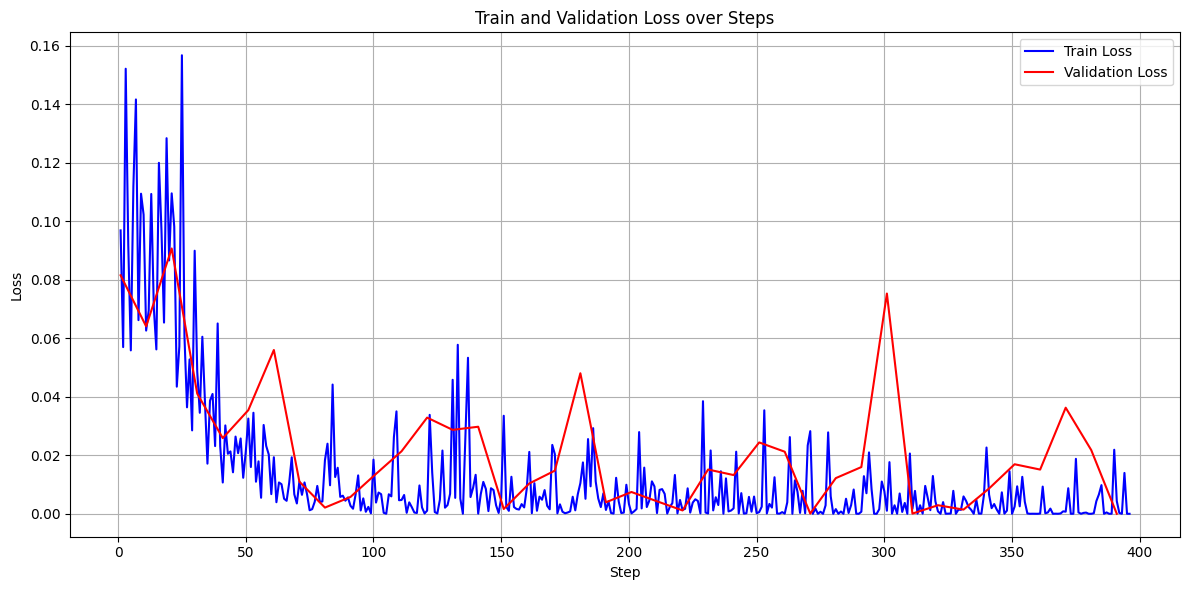

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
data = pd.read_csv('results.csv')

# Separate steps and values for training and validation data
train_step = data['step']
train_loss = data['train_loss']

valid_data = data.dropna(subset=['valid_loss'])
eval_step = valid_data['step']
eval_loss = valid_data['valid_loss']

# Plotting
plt.figure(figsize=(12, 6))

# Plot Train Loss
plt.plot(train_step, train_loss, label='Train Loss', color='blue')

# Plot Validation Loss
plt.plot(eval_step, eval_loss, label='Validation Loss', color='red')

plt.title('Train and Validation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

